# Apresentação e Objetivo
A nota dos participantes ENEM é calculado pelo INEP a partir dos padrões de respostas às questões das provas, com certas suposições:

* É usado um modelo IRT do tipo 3PL 
* Os parâmetros a, b e c (discriminação, dificuldade e chute, respectivamente) do modelo são calibrados para cada item previamente, por métodos de *linking* que coloquem novas itens na escala ENEM
* A estimativa do *score* na escala ENEM usa o método EAP ("Expected a posteriori")

O que quero fazer neste notebook é fazer uma certa análise de robustez das notas do ENEM atribuídas pelo INEP. Uma motivação é mostrar que o número atribuído a cada candidato deve ser interpretado. Quero chacoalhar um pouco na suposta objetividade da nota, a ideia que a prova ENEM reflete 

Uma maneira de fazer isso é criar uma série de contrafactuais, mudanças aparente inocentes no procedimento de cálculo das notas e estudar como a nota muda. Ou seja, estou imaginando uma espécie de propagação de incerteza, na linguagem de físicos: 

$$ \text{Nota ENEM} = f(\text{padrão de respostas},\text{parâmetros IRT},...) = f(\vec{x})$$
$$ \Delta f \approx \frac{\partial f}{\partial x} \Delta x$$



In [33]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import random
import scipy
from util import load_acertos,provas,score_inep,load_padr,item_info_inep, params_inep
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Reproduzir as notas do INEP
Antes de investigar o efeito de pequenas variações nos *inputs* e metodologia do cálculo, precisamos ter certeza que conseguimos reproduzir as notas que o INEP calcula. Há uma função `score_inep` em `util.py` que calcula 

In [11]:
# os código das provas (ou "cadernos") de um determinado ano e área
provas(2022,'CN')

array([1088, 1087, 1085, 1086])

In [21]:
# os padrões de resposta de uma deterinada prova (uma amostra aleatório de N candidatos)
# note que os labels das colunas são os códigos dos itens *em ordem ascendente*.
prova = 1088
load_padr(prova,3)

,18228,28034,28632,31313,31381,37769,41054,43073,44969,78377,...,126560,141503,141545,141547,141574,141597,141712,141725,141726,141731
candidato,,,,,,,,,,,,,,,,,,,,,
210057975308,0,0,0,1,0,0,0,0,0,0,...,1,0,0,0,1,0,0,0,0,0
210055094373,0,0,0,0,0,1,0,1,0,0,...,0,0,0,0,1,0,0,0,0,0
210056955521,0,0,0,0,0,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


In [42]:
# a mesma função pode também ser usado para obter as notas ENEM do INEP:
padr, notas_inep = load_padr(prova,3,nota_inep=True)
display(notas_inep,padr)

,acertos,caderno,nota_inep
candidato,,,
210056300709,14,1085,455.3
210055414457,10,1085,475.9
210057173606,12,1085,432.8


,18228,28034,28632,31313,31381,37769,41054,43073,44969,78377,...,126560,141503,141545,141547,141574,141597,141712,141725,141726,141731
candidato,,,,,,,,,,,,,,,,,,,,,
210056300709,0,0,0,0,0,1,0,0,0,0,...,0,1,0,0,0,0,0,0,1,1
210055414457,0,1,0,0,0,0,0,0,1,0,...,0,1,0,1,0,0,1,0,1,0
210057173606,0,1,0,1,0,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [48]:
# a função abaixo calcula a nota de uma determinda prova, dado um padrão de resposta
prova = 1088 # CN, 2022
padr, notas_inep = load_padr(prova,3,nota_inep=True)
notas_atp = score_inep(padr,prova)
display(notas_atp,notas_inep)

,nota,se
candidato,,
210056070600,0.118830,0.576504
210056389969,-0.989250,0.702137
210057135234,1.733095,0.171149


,acertos,caderno,nota_inep
candidato,,,
210056070600,12,1088,514.6
210056389969,12,1088,389.3
210057135234,28,1088,697.2


Note que a nota que calculamos está numa escala com média 0 e desvio padrão 1, usando o padrão da função [`mirt.fscores`](https://philchalmers.github.io/mirt/docs/reference/fscores.html) do pacote [mirt](https://philchalmers.github.io/mirt/docs/index.html) que estamos usando. 

Veremos mais abaixo que para converter notas nesta escala para a escala ENEM, devemos multiplicar por aproximadamente 100 e acrescentar 500 (os valores exatos depende da área, CN, MT, etc. )

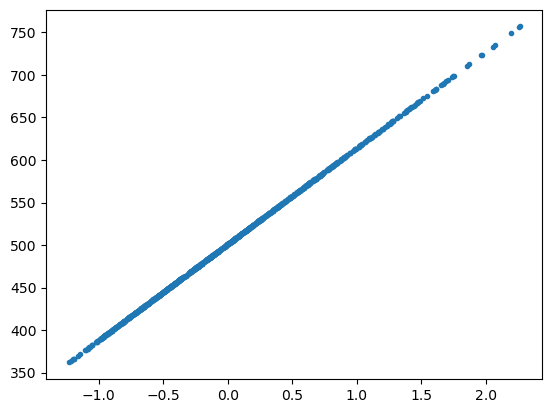

In [80]:
# e finalmente, vamos comparar o nosso cálculo a partir dos padrões de resposta 
# e os parâmetros IRT dado pelo INEP, com a nota do INEP dado nos microdados.
prova=1088
padr,notas_inep= load_padr(prova,1000,nota_inep=True)
notas_atp = score_inep(padr,prova)
x = notas_atp['nota']
y = notas_inep['nota_inep']
plt.plot(x,y,'.');

In [81]:
res = scipy.stats.linregress(x, y)
display(res)
print(f"\nslope = {res.slope}, intercept = {res.intercept}, stderr = {res.stderr}")

LinregressResult(slope=113.0906375860302, intercept=501.15006991463457, rvalue=0.999999921958002, pvalue=0.0, stderr=0.0014142969175127808, intercept_stderr=0.0009345762485156925)


slope = 113.0906375860302, intercept = 501.15006991463457, stderr = 0.0014142969175127808


Porém, veremos que nem sempre conseguimos reproduzir a nota do INEP perfeitamente. Há algum problema com alguns anos e áreas. Precisamos descobrir o que acontece.

Ano 2009 e prova = 51: slope = 113.0897978863137, intercept = 501.1486391566014, stderr = 0.0015831815691126415
Ano 2009 e prova = 50: slope = 113.0925962120066, intercept = 501.14804722312675, stderr = 0.0013757191180572461
Ano 2009 e prova = 52: slope = 113.08707173236856, intercept = 501.1512353181513, stderr = 0.0016670487357116094
Ano 2009 e prova = 49: slope = 113.08743361488567, intercept = 501.1520012774609, stderr = 0.001618568509592343
Ano 2010 e prova = 92: slope = 113.09342624305795, intercept = 501.1465411094105, stderr = 0.00143583652626502
Ano 2010 e prova = 91: slope = 113.09290329034022, intercept = 501.14980548528877, stderr = 0.0014251278788876573
Ano 2010 e prova = 90: slope = 113.27760532799513, intercept = 501.2292616699399, stderr = 0.08245025127487533
Ano 2010 e prova = 89: slope = 113.09303469455347, intercept = 501.1469040471342, stderr = 0.0015179544525494657
Ano 2012 e prova = 143: slope = 113.08095906086412, intercept = 501.14265894262525, stderr = 0.006707

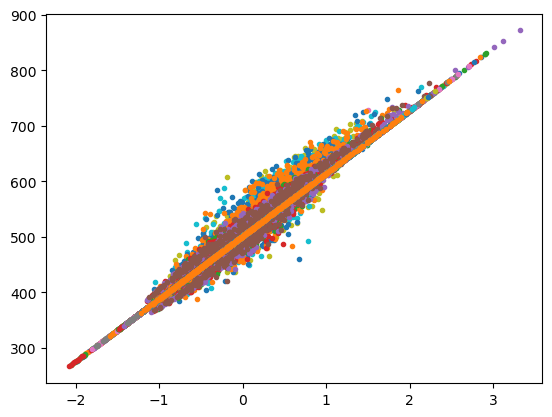

In [82]:
# vamos ter que pular o ano 2011 para a área CN, porque existe um item que não foi marcado como abandonado, mas para qual o INEP não deu os parâmetros IRT
# TODO: investigar se o item foi abandonado (conseguimos reproduzir as notas do INEP sem este item) OU se o item foi usado, mas não sabemos os parâmetros. 
results = []
for ano in range(2009,2023):
    if ano == 2011: # veja acima 
        continue
    provs = provas(ano,'CN')
    for prova in provs:
        padr,notas_inep= load_padr(prova,1000,nota_inep=True)
        
        notas = score_inep(padr,prova)
        
        x = notas['nota']
        y = notas_inep['nota_inep']
        plt.plot(x,y,'.')
        res = scipy.stats.linregress(x, y)
        print(f"Ano {ano} e prova = {prova}: slope = {res.slope}, intercept = {res.intercept}, stderr = {res.stderr}")
        results.append(res)

## Contrafactual: o candidato acerta ou erra uma questão a mais
O que acontece se por um acaso ou destração ou falta de tempo um candidato erra ou acerta um determinado item a mais ou a menos? Como isso influi na nota do ENEM. Talvez é interessante fazer esta análise para questões fáceis, de média dificuldade e difíceis? 

In [112]:
def flip_item(padr,item):
    padr2 = padr.copy()
    padr2[item] = 1 - padr[item] # flip the answers of one item
    return padr2

prova=1088 
padr1 = load_padr(prova,1000)
padr1

,18228,28034,28632,31313,31381,37769,41054,43073,44969,78377,...,126560,141503,141545,141547,141574,141597,141712,141725,141726,141731
candidato,,,,,,,,,,,,,,,,,,,,,
210056892545,0,0,0,1,0,0,1,0,1,0,...,0,0,0,0,1,1,0,0,0,1
210057553283,1,0,0,0,0,0,1,0,1,0,...,0,1,0,1,0,0,0,0,0,1
210056700645,1,0,0,0,0,1,0,0,0,0,...,0,1,0,0,1,1,1,0,1,0
210055558391,0,0,0,1,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
210057324003,1,1,0,0,0,0,0,1,0,0,...,1,1,0,0,1,1,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
210057798494,1,0,1,0,0,0,0,1,1,1,...,1,0,0,1,0,0,1,0,1,1
210057994757,1,1,0,0,0,0,1,0,1,0,...,1,1,1,0,0,0,1,0,0,1
210055096128,1,0,0,0,0,1,1,0,0,1,...,0,0,0,1,0,1,1,0,0,0


In [113]:
padr2 = flip_item(padr1,28034)
padr2

,18228,28034,28632,31313,31381,37769,41054,43073,44969,78377,...,126560,141503,141545,141547,141574,141597,141712,141725,141726,141731
candidato,,,,,,,,,,,,,,,,,,,,,
210056892545,0,1,0,1,0,0,1,0,1,0,...,0,0,0,0,1,1,0,0,0,1
210057553283,1,1,0,0,0,0,1,0,1,0,...,0,1,0,1,0,0,0,0,0,1
210056700645,1,1,0,0,0,1,0,0,0,0,...,0,1,0,0,1,1,1,0,1,0
210055558391,0,1,0,1,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
210057324003,1,0,0,0,0,0,0,1,0,0,...,1,1,0,0,1,1,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
210057798494,1,1,1,0,0,0,0,1,1,1,...,1,0,0,1,0,0,1,0,1,1
210057994757,1,0,0,0,0,0,1,0,1,0,...,1,1,1,0,0,0,1,0,0,1
210055096128,1,1,0,0,0,1,1,0,0,1,...,0,0,0,1,0,1,1,0,0,0


In [115]:
notas_atp1 = score_inep(padr1,prova)
notas_atp2 = score_inep(padr2,prova)
notas_atp1['nota'] - notas_atp2['nota']

candidato
210056892545   -0.113890
210057553283   -0.179892
210056700645   -0.103174
210055558391   -0.100379
210057324003    0.059148
                  ...   
210057798494   -0.166769
210057994757    0.065841
210055096128   -0.173583
210055671567   -0.161252
210056689901   -0.146251
Name: nota, Length: 1000, dtype: float64

## Contrafactual: mudanças nos parâmetros IRT
O INEP calibrou os parâmetros a,b e c dos itens que usaram. Como a nota ENEM mudaria se estes parâmetros variam (um pouco)? Afinal, a própria determinação dos parâmetros introduz uma incerteza nestes parâmetros. Como esta incerteza se propaga na nota ENEM?

In [71]:
# Esta função usa o arquivo data/itens_inep.csv para extrair os parâmetros dos itens dado pelo INEP
prova = 1088
params = params_inep(prova)
params

,a_inep,b_inep,c_inep,u
CO_ITEM,,,,
18228,1.95358,1.46498,0.11246,1
28034,1.51222,1.41874,0.14908,1
28632,1.99451,1.78678,0.12762,1
31313,1.71131,1.42364,0.16150,1
31381,1.75013,1.52509,0.16155,1
37769,1.78429,2.50062,0.27071,1
41054,1.20120,0.97602,0.22536,1
43073,1.48588,0.96735,0.24215,1
44969,3.07166,1.89127,0.25272,1


In [73]:
prova = 1088
params = params_inep(prova)
params2 = params_inep(prova)
# mudar o parâmetro b aleatoriamente aprox. 10%
params2['b_inep'] = params2['b_inep']*(1+0.1*np.random.normal(size=len(params)))
params2 - params

,a_inep,b_inep,c_inep,u
CO_ITEM,,,,
18228,0.0,-0.131137,0.0,0
28034,0.0,0.173882,0.0,0
28632,0.0,-0.218090,0.0,0
31313,0.0,0.019558,0.0,0
31381,0.0,-0.181586,0.0,0
37769,0.0,-0.107434,0.0,0
41054,0.0,0.033523,0.0,0
43073,0.0,0.043333,0.0,0
44969,0.0,0.382603,0.0,0


In [78]:
prova = 1088
params1 = params_inep(prova)
params2 = params_inep(prova)
# mudar o parâmetro b aleatoriamente aprox. 10%
params2['b_inep'] = params2['b_inep']*(1+0.1*np.random.normal(size=len(params1)))
padr, notas_inep = load_padr(prova,1000,nota_inep=True)
# podemos usara params na função score_
notas1 = score_inep(padr,params=params1)
notas2 = score_inep(padr,params=params2)
diff = (notas1 - notas2)['nota']
display(diff)
diff.describe()

candidato
210055530840    0.022193
210057099774    0.066078
210056798145   -0.016088
210054835019    0.016714
210056740674    0.006490
                  ...   
210057527267    0.044265
210056344389    0.027388
210054543065    0.005418
210054838526    0.058907
210056048502   -0.014084
Name: nota, Length: 1000, dtype: float64

count    1000.000000
mean        0.009704
std         0.053300
min        -0.230877
25%        -0.023474
50%         0.011951
75%         0.044147
max         0.247515
Name: nota, dtype: float64

## Contrafactual: usar outro método do EAP 
Vamos ver o efeito de usar MAP ou ML

In [57]:
prova=1088 # CN, 2022
slope, intercept = 113.091, 501.150

padr,notas_inep= load_padr(prova,1000,nota_inep=True)
notas_atp = score_inep(padr,prova)

notas_inep['nota_inep'] - (notas_atp['nota']*slope + intercept)

candidato
210057603415   -0.046262
210056997508   -0.025438
210057377114   -0.015732
210057092200    0.006256
210056455088   -0.035717
                  ...   
210055123313    0.015286
210057501893   -0.009950
210056326271    0.009483
210055975622   -0.053685
210054987615   -0.043226
Length: 1000, dtype: float64

In [59]:
n1 = score_inep(padr,prova)
n2 = score_inep(padr,prova,method='MAP')
n1['nota'] - n2['nota']

candidato
210057603415   -0.258926
210056997508   -0.249042
210057377114   -0.284468
210057092200   -0.192446
210056455088   -0.237896
                  ...   
210055123313   -0.041843
210057501893   -0.159387
210056326271   -0.054435
210055975622   -0.210276
210054987615   -0.129758
Name: nota, Length: 1000, dtype: float64

In [60]:
(n1['nota'] - n2['nota']).describe()

count    1000.000000
mean       -0.219736
std         0.109718
min        -0.626621
25%        -0.287963
50%        -0.221241
75%        -0.155742
max         0.047604
Name: nota, dtype: float64

In [62]:
n1 = score_inep(padr,prova)
n2 = score_inep(padr,prova,method='ML')
(n1['nota'] - n2['nota'])

candidato
210057603415   -0.257938
210056997508    0.181118
210057377114   -0.319535
210057092200         inf
210056455088   -0.292013
                  ...   
210055123313   -0.092120
210057501893   -0.157405
210056326271   -0.095986
210055975622   -0.224849
210054987615   -0.172722
Name: nota, Length: 1000, dtype: float64

In [69]:
(n1['nota'] - n2['nota']).replace([np.inf, -np.inf], np.nan).dropna().describe()

count    876.000000
mean      -0.141648
std        0.347117
min       -0.699673
25%       -0.283582
50%       -0.199166
75%       -0.104971
max        2.431584
Name: nota, dtype: float64

## Contrafactual: usar soma dos acertos ao vez de IRT
A mudança mais radical no cálculo da nota seria não usar IRT e sim a soma dos acertos dos itens. Sabemos que existem bons argumentos para usar IRT e que isso não é uma decisão arbitrária, mas mesmo assim vale a pena visual como, *em princípio*, a nota do candidato poderia ter sido bastante diferente.

Vamos usar uma função load_acertos em util.py que além dos padrões de respostas tras mais três colunas: o número de acertos, o código da prova e a nota que o INEP calculou.

In [6]:
load_acertos(2022,'CN',3)

,117854,141545,78377,97761,78716,96189,141712,43073,141574,18228,...,28632,126560,97727,28034,97915,141503,88655,acertos,caderno,nota_inep
candidato,,,,,,,,,,,,,,,,,,,,,
210055540729,1,0,1,0,1,1,0,0,1,0,...,0,0,0,0,1,1,0,14,1086,497.3
210055689725,0,0,1,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,5,1086,422.8
210057963005,0,0,1,0,0,0,0,1,0,0,...,0,0,0,1,0,0,0,6,1085,410.1


<AxesSubplot:xlabel='acertos', ylabel='nota_inep'>

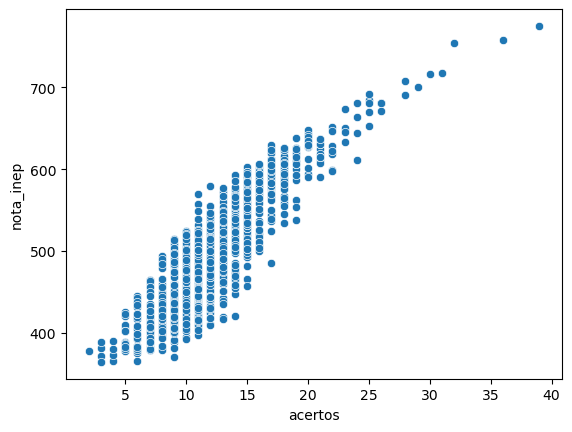

In [7]:
data = load_acertos(2022,'CN',1000)
sns.scatterplot(data,x='acertos',y='nota_inep');

In [10]:
data.query('acertos == 10')['nota_inep'].describe()

count     95.000000
mean     459.762105
std       31.438377
min      393.200000
25%      435.300000
50%      459.900000
75%      479.000000
max      524.500000
Name: nota_inep, dtype: float64

Vemos que candidatos com por exemplo 10 acertos são atribuidos notas ENEM que variam de 393 até 524.